In [1]:
import sys
sys.path.insert(0, '/home/eddieh00/UCSD/ms/ece228/bmi_model/facenet/src')
import facenet
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split


In [2]:
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1 / std_adj)
    return y

def load_and_preprocess_image(image_path, image_size):
    try:
        # Load image
        image = Image.open(image_path)
        image = image.resize(image_size)
        image = np.array(image)

        # Preprocess the image
        image = prewhiten(image)

        return image
    except FileNotFoundError:
        print("File not found: " + str(image_path))
        return None

def generate_embeddings(image_paths, labels, model_path, image_size):
    assert len(image_paths) == len(labels), "Number of image paths and labels must be the same."
    
    with tf.Graph().as_default():
        with tf.Session() as sess:
            # Load the facenet model
            facenet.load_model(model_path)

            # Get input and output tensors
            input_tensor = tf.get_default_graph().get_tensor_by_name("input:0")
            output_tensor = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_tensor = tf.get_default_graph().get_tensor_by_name("phase_train:0")

            # Generate embeddings and matching labels
            embeddings = []
            matching_labels = []
            for image_path, label in zip(image_paths, labels):
                image = load_and_preprocess_image(image_path, image_size)
                if image is not None:
                    image = np.expand_dims(image, axis=0)
                    emb = sess.run(output_tensor, feed_dict={input_tensor: image, phase_train_tensor: False})
                    embeddings.append(emb.flatten())
                    matching_labels.append(label)

            embeddings = np.array(embeddings)

    return embeddings, matching_labels


def generate_test_embeddings(image_paths, model_path, image_size):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            # Load the facenet model
            facenet.load_model(model_path)

            # Get input and output tensors
            input_tensor = tf.get_default_graph().get_tensor_by_name("input:0")
            output_tensor = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_tensor = tf.get_default_graph().get_tensor_by_name("phase_train:0")

            # Generate embeddings and matching labels
            embeddings = []
            for image_path in image_paths:
                image = load_and_preprocess_image(image_path, image_size)
                if image is not None:
                    image = np.expand_dims(image, axis=0)
                    emb = sess.run(output_tensor, feed_dict={input_tensor: image, phase_train_tensor: False})
                    embeddings.append(emb.flatten())

            embeddings = np.array(embeddings)

    return embeddings


In [3]:
from data_model import DataGenerator
base_path = '/home/eddieh00/UCSD/ms/ece228/bmi_model/data/faces_precropped'
csv_file = 'faces_precropped.csv'  # Replace with your CSV file name
model_path = '/home/eddieh00/UCSD/ms/ece228/bmi_model/facenet/best_facenet_model'
image_size = (160, 160)
batch_size = 32

# Load the CSV file
df = pd.read_csv(os.path.join(base_path, csv_file))
image_paths = [os.path.join(base_path, filename) for filename in df['bookid']]
labels = np.array(df['bmi'])

# Generate embeddings
embeddings, labels = generate_embeddings(image_paths, labels, model_path, image_size)
labels = np.array(labels)

# Split the data into training, test, and validation sets
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42)
test_embeddings, val_embeddings, test_labels, val_labels = train_test_split(
    test_embeddings, test_labels, test_size=0.5, random_state=42)

# Create data loader objects
train_data_loader = DataGenerator(train_embeddings, train_labels, batch_size)
test_data_loader = DataGenerator(test_embeddings, test_labels, batch_size)
val_data_loader = DataGenerator(val_embeddings, val_labels, batch_size)

Model directory: /home/eddieh00/UCSD/ms/ece228/bmi_model/facenet/best_facenet_model
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /home/eddieh00/UCSD/ms/ece228/bmi_model/facenet/best_facenet_model/model-20180402-114759.ckpt-275
File not found: /home/eddieh00/UCSD/ms/ece228/bmi_model/data/faces_precropped/_daewon_(lee_daewon 대원).jpg
File not found: /home/eddieh00/UCSD/ms/ece228/bmi_model/data/faces_precropped/_damon_(qiū_báo_hàn).jpg
File not found: /home/eddieh00/UCSD/ms/ece228/bmi_model/data/faces_precropped/_ha_bin_(ha_bin 하빈).jpg
File not found: /home/eddieh00/UCSD/ms/ece228/bmi_model/data/faces_precropped/_harang_(park_ha_rang 하랑).jpg
File not found: /home/eddieh00/UCSD/ms/ece228/bmi_model/data/faces_precropped/_manny_(xiào_dōngchéng).jpg
File not found: /home/eddieh00/UCSD/ms/ece228/bmi_model/data/faces_precropped/_xin_(wáng_xīnyû).jpg
File not found: /home/eddieh00/UCSD/ms/ece228/bmi_model/data

In [4]:
from bmi_custom_model import BMI_Estimator

training_data = train_data_loader
validation_data = val_data_loader
epochs = 40
save = True
save_path = '/home/eddieh00/UCSD/ms/ece228/bmi_model/bmi_model/saved models'

model = BMI_Estimator()
model.train(training_data, validation_data, epochs, save, save_path)

Epoch 0 Train Loss: 20.157147102355957 Validation Loss: 10.630837069617378
INFO:tensorflow:/home/eddieh00/UCSD/ms/ece228/bmi_model/bmi_model/saved models/epoch_0/model_weights.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch 1 Train Loss: 6.294291718800863 Validation Loss: 4.43633755048116
INFO:tensorflow:/home/eddieh00/UCSD/ms/ece228/bmi_model/bmi_model/saved models/epoch_1/model_weights.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch 2 Train Loss: 3.6996482467651366 Validation Loss: 3.7863952583736844
INFO:tensorflow:/home/eddieh00/UCSD/ms/ece228/bmi_model/bmi_model/saved models/epoch_2/model_weights.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch 3 Train Loss: 3.246403840382894 Validation Loss: 3.3813439740075006
INFO:tensorflow:/home/eddieh00/UCSD/ms/ece228/bmi_model/bmi_model/saved models/epoch_3/model_weights.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch 4 Train Loss: 2.9656936875979105 Validatio

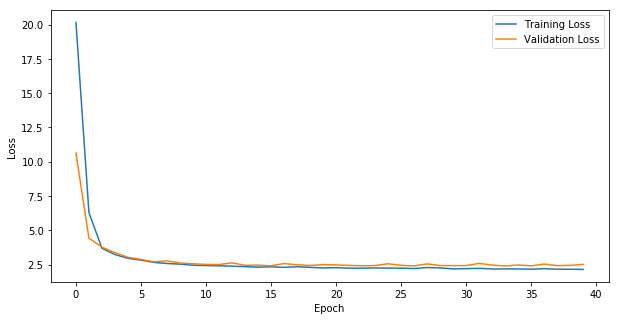

In [6]:
import csv
import matplotlib.pyplot as plt

losses_path = '/home/eddieh00/UCSD/ms/ece228/bmi_model/bmi_model/saved models/losses.csv'

with open(losses_path, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    epochs, train_losses, val_losses = [], [], []
    for row in reader:
        epoch, train_loss, val_loss = map(float, row)
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


